In [69]:
"""импортируем необходимые библиотеки
модуль mailbox позволяет взаимодействовать с содержимым почты в виде словаря"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mailbox
import csv
import re
import time
from datetime import datetime, timezone
import pytz
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [3]:
"""Читаем файл. Передаем  в переменную mboxfile путь к файлу на диске"""

mboxfile = 'D:\\datasets\\EDA Gmail\\Takeout\\Почта\\Вся почта, включая _Спам_ и _Корзину_.mbox'
mbox = mailbox.mbox(mboxfile)

In [4]:
"""Данные моей почты содержат 24 ключа, которые во многом соответствуют названиям папок в Gmail: Received. From, Subject, To и так далее.
Очевидно, использование всех 24 ключей не является целесообразным, поэтому запишем необходимые для анализа пары key-value в csv файл, 
из которого в дальнейшем сформируем DataFrame."""

with open('mailbox.csv', 'w', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Subject', 'From', 'Date', 'To', 'Label', 'Thread'])
    for message in mbox:
        writer.writerow([
            message['Subject'],
            message['From'],
            message['Date'],
            message['To'],
            message['X-Gmail-Labels'],
            message['X-GM-THRID']
        ])

In [5]:
df = pd.read_csv('mailbox.csv', names=['Subject', 'From', 'Date', 'To', 'Label', 'Thread'])
df.head()

,Subject,From,Date,To,Label,Thread
0,Subject,From,Date,To,Label,Thread
1,FleetMon News Daily Digest for alexstanislav1,FleetMon News <noreply@fleetmon.com>,"Sun, 04 Apr 2021 16:03:30 +0000",skaz63@gmail.com,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1696126427036058553
2,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,"""Ingate"" <mail@ingate-news.ru>","Tue, 30 Mar 2021 14:43:54 +0000",skaz63@gmail.com,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695668464435915634
3,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,"""Bileter.ru"" <account@bileter.ru>","Thu, 01 Apr 2021 07:51:50 -0700 (PDT)","""skaz63@gmail.com"" <skaz63@gmail.com>",=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695850126916889638
4,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,"""M.Video"" <ORDERS@SENDER.MVIDEO.RU>","Thu, 01 Apr 2021 12:57:36 +0300",SKAZ63@GMAIL.COM,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695830742310636234


In [6]:
"""Посмотрим на тип данных для каждой колонки датафрейма"""

df.dtypes

Subject    object
From       object
Date       object
To         object
Label      object
Thread     object
dtype: object

In [7]:
"""Необходимо обратить внимание, что тип данных для дата - object, поэтому его нужно конвертировать в DateTime"""

df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x, errors='coerce',utc=True))
df.head()

c:\users\konstantin\appdata\local\programs\python\python39\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname UT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,Subject,From,Date,To,Label,Thread
0,Subject,From,NaT,To,Label,Thread
1,FleetMon News Daily Digest for alexstanislav1,FleetMon News <noreply@fleetmon.com>,2021-04-04 16:03:30+00:00,skaz63@gmail.com,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1696126427036058553
2,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,"""Ingate"" <mail@ingate-news.ru>",2021-03-30 14:43:54+00:00,skaz63@gmail.com,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695668464435915634
3,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,"""Bileter.ru"" <account@bileter.ru>",2021-04-01 14:51:50+00:00,"""skaz63@gmail.com"" <skaz63@gmail.com>",=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695850126916889638
4,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,"""M.Video"" <ORDERS@SENDER.MVIDEO.RU>",2021-04-01 09:57:36+00:00,SKAZ63@GMAIL.COM,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695830742310636234


In [8]:
"""Далее необходимо в столбце Date удалить все NaN-значения"""

df = df[df['Date'].notna()]
df.head()

,Subject,From,Date,To,Label,Thread
1,FleetMon News Daily Digest for alexstanislav1,FleetMon News <noreply@fleetmon.com>,2021-04-04 16:03:30+00:00,skaz63@gmail.com,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1696126427036058553
2,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,"""Ingate"" <mail@ingate-news.ru>",2021-03-30 14:43:54+00:00,skaz63@gmail.com,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695668464435915634
3,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,"""Bileter.ru"" <account@bileter.ru>",2021-04-01 14:51:50+00:00,"""skaz63@gmail.com"" <skaz63@gmail.com>",=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695850126916889638
4,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,"""M.Video"" <ORDERS@SENDER.MVIDEO.RU>",2021-04-01 09:57:36+00:00,SKAZ63@GMAIL.COM,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695830742310636234
5,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,"""M.Video"" <ORDERS@SENDER.MVIDEO.RU>",2021-04-01 09:41:23+00:00,SKAZ63@GMAIL.COM,=?UTF-8?B?0JLRhdC+0LTRj9GJ0LjQtSzQmtCw0YLQtdCz...,1695830742310636234


In [132]:
df.to_csv('gmail.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27927 entries, 1 to 27955
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   Subject  27794 non-null  object             
 1   From     27927 non-null  object             
 2   Date     27927 non-null  datetime64[ns, UTC]
 3   To       27901 non-null  object             
 4   Label    27927 non-null  object             
 5   Thread   27927 non-null  object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 1.5+ MB


In [10]:
"""Отмечу, что в столбце From содержится как сам email, так и его название. Например, "M.Video" <ORDERS@SENDER.MVIDEO.RU>
Оставим только сам email."""

def extract_email(string):
    email = re.findall(r'<(.+?)>', string)
    if not email:
        email = list(filter(lambda y: '@' in y, string.split()))
    return email[0] if email else np.nan

In [28]:
df['From'] = df['From'].apply(lambda x: extract_email(x.lower()))
df['To'] = df['To'].apply(lambda x: extract_email(str(x).lower()))

In [36]:
"""Преобразуем столбец Label. Отнесём каждое письмо к категории отправленные или полученных"""

myemail = 'skaz63@gmail.com'
df['Label'] = df['From'].apply(lambda x: 'sent' if myemail in x else 'inbox')
df.head()

,Subject,From,Date,To,Label,Thread
1,FleetMon News Daily Digest for alexstanislav1,noreply@fleetmon.com,2021-04-04 16:03:30+00:00,skaz63@gmail.com,inbox,1696126427036058553
2,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,mail@ingate-news.ru,2021-03-30 14:43:54+00:00,skaz63@gmail.com,inbox,1695668464435915634
3,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,account@bileter.ru,2021-04-01 14:51:50+00:00,skaz63@gmail.com,inbox,1695850126916889638
4,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 09:57:36+00:00,skaz63@gmail.com,inbox,1695830742310636234
5,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 09:41:23+00:00,skaz63@gmail.com,inbox,1695830742310636234


In [39]:
"""Отмечу, что время в столбце Date представлено в часовоем поясе, который отличается от московского на -3 часа. 
Исправим это"""

def datetime_from_utc_to_local(utc_datetime):
    now_timestamp = time.time()
    offset = datetime.fromtimestamp(now_timestamp) - datetime.utcfromtimestamp(now_timestamp)
    return utc_datetime + offset
df['Date'] = df['Date'].apply(lambda x: datetime_from_utc_to_local(x))

In [40]:
df.head()

,Subject,From,Date,To,Label,Thread
1,FleetMon News Daily Digest for alexstanislav1,noreply@fleetmon.com,2021-04-04 19:03:30+00:00,skaz63@gmail.com,inbox,1696126427036058553
2,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,mail@ingate-news.ru,2021-03-30 17:43:54+00:00,skaz63@gmail.com,inbox,1695668464435915634
3,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,account@bileter.ru,2021-04-01 17:51:50+00:00,skaz63@gmail.com,inbox,1695850126916889638
4,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 12:57:36+00:00,skaz63@gmail.com,inbox,1695830742310636234
5,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 12:41:23+00:00,skaz63@gmail.com,inbox,1695830742310636234


In [41]:
"""Добавим в датафрейм столбец с днем недели"""

df['Week_Day'] = df['Date'].dt.strftime('%A')
df

,Subject,From,Date,To,Label,Thread,Week_Day
1,FleetMon News Daily Digest for alexstanislav1,noreply@fleetmon.com,2021-04-04 19:03:30+00:00,skaz63@gmail.com,inbox,1696126427036058553,Sunday
2,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,mail@ingate-news.ru,2021-03-30 17:43:54+00:00,skaz63@gmail.com,inbox,1695668464435915634,Tuesday
3,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,account@bileter.ru,2021-04-01 17:51:50+00:00,skaz63@gmail.com,inbox,1695850126916889638,Thursday
4,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 12:57:36+00:00,skaz63@gmail.com,inbox,1695830742310636234,Thursday
5,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 12:41:23+00:00,skaz63@gmail.com,inbox,1695830742310636234,Thursday
...,...,...,...,...,...,...,...
27951,=?UTF-8?Q?=D0=A1=D0=B0=D0=BC=D0=B0=D1=8F_=D1=8...,mail@depositphotos.com,2020-12-15 12:19:30+00:00,skaz63@gmail.com,inbox,1686135343956591468,Tuesday
27952,=?utf-8?Q?=D0=98=D0=B7=D1=83=D1=87=D0=B8=D1=82...,noreply@stepik.org,2020-09-19 15:19:47+00:00,skaz63@gmail.com,inbox,1678292457707487345,Saturday
27953,=?utf-8?Q?=5B=F0=9F=91=81=EF=B8=8F=5D=20?=\r\n...,news@news.ozon.ru,2021-03-18 19:03:19+00:00,skaz63@gmail.com,inbox,1694586270031769230,Thursday
27954,=?utf-8?Q?=D0=9F=D0=BE=D0=BB=D1=83=D1=87=D0=B8...,news@news.ozon.ru,2020-10-08 11:57:17+00:00,skaz63@gmail.com,inbox,1679973353122254363,Thursday


In [43]:
"""Добавим в датафрейм столбец со временем в течение дня"""

df['Day_Time'] = df['Date'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

"""Добавим в датафрейм столбец с указанием часа"""

df['Hour'] = df['Date'].apply(lambda x: x.hour)

"""Добавим в датафрейм столбец с указанием года"""

df['Year_int'] = df['Date'].apply(lambda x: x.year)


"""Добавим в датафрейм столбец с указанием года 2"""

df['Year'] = df['Date'].apply(lambda x: x.year + x.dayofyear/365.25)

In [44]:
df

,Subject,From,Date,To,Label,Thread,Week_Day,Day_Time,Hour,Year_int,Year
1,FleetMon News Daily Digest for alexstanislav1,noreply@fleetmon.com,2021-04-04 19:03:30+00:00,skaz63@gmail.com,inbox,1696126427036058553,Sunday,19.058333,19,2021,2021.257358
2,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,mail@ingate-news.ru,2021-03-30 17:43:54+00:00,skaz63@gmail.com,inbox,1695668464435915634,Tuesday,17.731667,17,2021,2021.243669
3,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,account@bileter.ru,2021-04-01 17:51:50+00:00,skaz63@gmail.com,inbox,1695850126916889638,Thursday,17.863889,17,2021,2021.249144
4,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 12:57:36+00:00,skaz63@gmail.com,inbox,1695830742310636234,Thursday,12.960000,12,2021,2021.249144
5,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,2021-04-01 12:41:23+00:00,skaz63@gmail.com,inbox,1695830742310636234,Thursday,12.689722,12,2021,2021.249144
...,...,...,...,...,...,...,...,...,...,...,...
27951,=?UTF-8?Q?=D0=A1=D0=B0=D0=BC=D0=B0=D1=8F_=D1=8...,mail@depositphotos.com,2020-12-15 12:19:30+00:00,skaz63@gmail.com,inbox,1686135343956591468,Tuesday,12.325000,12,2020,2020.958248
27952,=?utf-8?Q?=D0=98=D0=B7=D1=83=D1=87=D0=B8=D1=82...,noreply@stepik.org,2020-09-19 15:19:47+00:00,skaz63@gmail.com,inbox,1678292457707487345,Saturday,15.329722,15,2020,2020.720055
27953,=?utf-8?Q?=5B=F0=9F=91=81=EF=B8=8F=5D=20?=\r\n...,news@news.ozon.ru,2021-03-18 19:03:19+00:00,skaz63@gmail.com,inbox,1694586270031769230,Thursday,19.055278,19,2021,2021.210815
27954,=?utf-8?Q?=D0=9F=D0=BE=D0=BB=D1=83=D1=87=D0=B8...,news@news.ozon.ru,2020-10-08 11:57:17+00:00,skaz63@gmail.com,inbox,1679973353122254363,Thursday,11.954722,11,2020,2020.772074


In [45]:
df.index = df['Date']
del df['Date']

In [46]:
df

,Subject,From,To,Label,Thread,Week_Day,Day_Time,Hour,Year_int,Year
Date,,,,,,,,,,
2021-04-04 19:03:30+00:00,FleetMon News Daily Digest for alexstanislav1,noreply@fleetmon.com,skaz63@gmail.com,inbox,1696126427036058553,Sunday,19.058333,19,2021,2021.257358
2021-03-30 17:43:54+00:00,=?UTF-8?Q?=D0=92=D0=B5=D0=B1=D0=B8=D0=BD=D0=B0...,mail@ingate-news.ru,skaz63@gmail.com,inbox,1695668464435915634,Tuesday,17.731667,17,2021,2021.243669
2021-04-01 17:51:50+00:00,=?UTF-8?Q?=D0=9F=D1=80=D0=B8=D0=B3=D0=BB=D0=B0...,account@bileter.ru,skaz63@gmail.com,inbox,1695850126916889638,Thursday,17.863889,17,2021,2021.249144
2021-04-01 12:57:36+00:00,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,skaz63@gmail.com,inbox,1695830742310636234,Thursday,12.960000,12,2021,2021.249144
2021-04-01 12:41:23+00:00,=?UTF-8?B?0JfQsNC60LDQtyDihJYgMTUyMTkyNjc2Nw==?=,orders@sender.mvideo.ru,skaz63@gmail.com,inbox,1695830742310636234,Thursday,12.689722,12,2021,2021.249144
...,...,...,...,...,...,...,...,...,...,...
2020-12-15 12:19:30+00:00,=?UTF-8?Q?=D0=A1=D0=B0=D0=BC=D0=B0=D1=8F_=D1=8...,mail@depositphotos.com,skaz63@gmail.com,inbox,1686135343956591468,Tuesday,12.325000,12,2020,2020.958248
2020-09-19 15:19:47+00:00,=?utf-8?Q?=D0=98=D0=B7=D1=83=D1=87=D0=B8=D1=82...,noreply@stepik.org,skaz63@gmail.com,inbox,1678292457707487345,Saturday,15.329722,15,2020,2020.720055
2021-03-18 19:03:19+00:00,=?utf-8?Q?=5B=F0=9F=91=81=EF=B8=8F=5D=20?=\r\n...,news@news.ozon.ru,skaz63@gmail.com,inbox,1694586270031769230,Thursday,19.055278,19,2021,2021.210815


# Анализ данных

## Вопросы, поставленные в ходе анализа
1. Сколько писем я отправил за заданный промежуто времени?
2. В какое время дня я отправляю и получаю письма?
3. Какое среднее количество писем в день?
4. Какое среднее количество писем в час?
5. С кем чаще всего осуществляется переписка?
6. В какие дни чаще всего происходит отправка/получение писем?
7. Какие основные темы писем?
8. Как менялись темы писем в течение времени?

### Ответ на первый вопрос: Сколько писем я отправил за заданный промежуто времени?

In [47]:
print(df.index.min().strftime('%a, %d %b %Y %I:%M %p'))
print(df.index.max().strftime('%a, %d %b %Y %I:%M %p'))
print(df['Label'].value_counts())

Mon, 06 Feb 2012 09:48 PM
Tue, 06 Apr 2021 07:02 PM
inbox    27240
sent       687
Name: Label, dtype: int64


#### Исходя из полученного ответа видно, что в период с 06 февраля 2012 года (господи, как давно это было) по 06 апреля 2021 года было отправлено 687 писем и получено 27 240 писем

### Ответ на второй вопрос: В какое время дня я отправляю и получаю письма?
#### Для ответа на этот вопрос предлагаю построить график на основе двух новосформированных датасетов: sent и received

In [53]:
sent = df.query("Label == 'sent'")
received = df.query("Label == 'inbox'")

In [79]:
"""Создадим функцию, которая на вход принимает датасет и отрисовывает график рассеивания"""
def create_plot(df, ax, color='C0', s=0.5, title=''):
    ind = np.zeros(len(df), dtype='bool')
    est = pytz.timezone('Europe/Moscow')
    df[~ind].plot.scatter('Year', 'Day_Time', s=s, alpha=0.6, ax=ax, color=color)
    ax.set_ylim(0, 24)
    ax.yaxis.set_major_locator(MaxNLocator(8))
    ax.set_yticklabels([datetime.strptime(str(int(np.mod(ts,24))), "%H").strftime("%H") for ts in ax.get_yticks()])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title)
    ax.grid(ls=':', color='k')
    return ax

<ipython-input-79-6ea986f10fcf>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([datetime.strptime(str(int(np.mod(ts,24))), "%H").strftime("%H") for ts in ax.get_yticks()])


<AxesSubplot:title={'center':'Received'}>

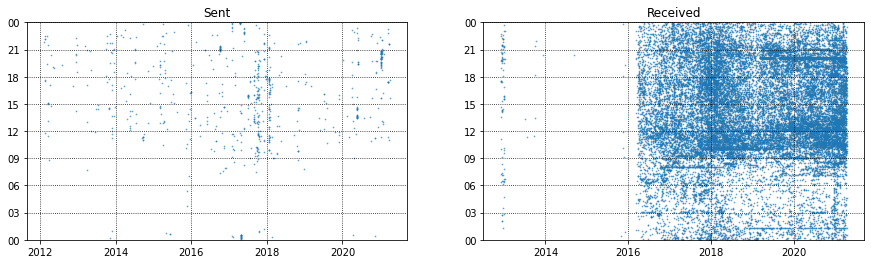

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
create_plot(sent, ax[0], title='Sent')
create_plot(received, ax[1], title='Received')

#### Можно сделать вывод, что чаще всего я отправляю письма в период с 12 дня до 21 вечера. Получение писем происходит, как видно на графике, в два этапа. Первый приходится на период с 09 утра до 12 дня, а второй на промежуток с 18 до 21 вечера.